# <font color= Purple>Gesture Recognition </font>
In this project, we're developing a sophisticated gesture recognition system tailored for smart TVs. Our approach extends beyond traditional remote controls, allowing users to effortlessly control their TV experience using intuitive hand gestures captured by a webcam.

Here's a glimpse of the system functions:

- Thumbs up: Increases volume
- Thumbs down: Decreases volume
- Left swipe: Rewinds by 10 seconds
- Right swipe: Fast-forwards by 10 seconds
- Stop: Pauses the movie
By seamlessly integrating these gestures, users can navigate and manage their TV viewing without the need for a physical remote.

#### Training Data
Our training dataset comprises hundreds of videos, each categorized into one of five distinct classes. These videos, spanning 2-3 seconds each, are segmented into sequences of 30 frames. They feature diverse individuals executing one of the five gestures in front of a webcam, closely simulating real-world interactions with the smart TV.

Our approach to model development goes beyond conventional Conv3D architectures. We've delved into innovative techniques, including the integration of transfer learning methodologies such as MobileNet combined with GRU, and TimeDistributed Conv2D coupled with GRU. Through meticulous experimentation, we optimized parameters like batch size, image index ranges and length, learning rate, and the strength of dropout layers, alongside fine-tuning L1 and L2 regularization techniques.

In [1]:
## Importing the necessary libraries
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import resize
from skimage.util import crop
from skimage import io
# using skimage libraries for reading, resizing and cropping images
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/val.csv').readlines())


In this block, the folder names are read for training and validation.

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition/train'
val_path = '/kaggle/input/gesture-recognition/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [5]:
def plot_graph(model_history):
    train_acc = model_history.history['categorical_accuracy']
    val_acc = model_history.history['val_categorical_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Generator
The generator function is a crucial part of the code, enabling the network to receive data for each epoch while managing memory constraints. It preprocesses images to ensure a consistent square aspect ratio, considering two different image dimensions: 360x360 and 120x160. Throughout the project, square aspect ratio images are prioritized. The function takes inputs such as source path (for training/validation), a list of items, batch size, number of images per sequence, and image size. Images are transformed iteratively during each batch iteration, adjusting their size using cropping and resizing techniques from the skimage library.

In [6]:
def custom_generator(source_path, folder_list, batch_size, img_idx, image_size):
    print('Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        for batch in range(num_batches): # Iterate over the number of batches
            # Initialize batch data and labels arrays
            batch_data = np.zeros((batch_size, len(img_idx), image_size, image_size, 3)) # Batch size, number of images per data point, image size (x and y), RGB channels
            batch_labels = np.zeros((batch_size, 5)) # One hot representation of output labels

            for folder in range(batch_size): # Iterate over the batch size
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]) # Read all images in the folder
                for idx, item in enumerate(img_idx): # Iterate over frames/images of a folder to read them
                    image = io.imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:  # Resize and crop based on incoming image size
                        crop_amount = ((120 - 120) // 2, (160 - 120) // 2)
                        image = crop(image, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))
                        image = resize(image, (image_size, image_size))
                    else:
                        image = resize(image, (image_size, image_size))

                    # Normalize RGB channels
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels # Yield the batch data and labels

        # For remaining data points after full batches
        if (len(folder_list) % batch_size) != 0:
            print("Batch: ", num_batches + 1, "Index:", batch_size, "Remaining data code")
            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros((batch_size, len(img_idx), image_size, image_size, 3))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = io.imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        crop_amount = ((120 - 120) // 2, (160 - 120) // 2)
                        image = crop(image, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))
                        image = resize(image, (image_size, image_size))
                    else:
                        image = resize(image, (image_size, image_size))

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Sample Cropping and resizing of images

In [ ]:
# Load an image of size 120x160
img = io.imread('/datasets/Project_data/train/WIN_20180907_15_41_54_Pro_Right Swipe_new/WIN_20180907_15_41_54_Pro_00015.png')
img.shape

(360, 360, 3)

Rendering the image

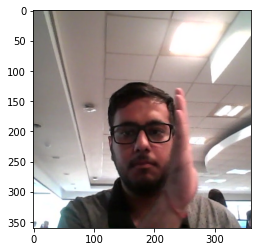

In [ ]:
plt.imshow(img)
plt.show()

image = crop(image, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))Cropping and resizing

In [ ]:
h, w, _ = img.shape

if h == 120 and w == 160:
    # Calculate cropping amount for each side
    crop_amount = ((h - 120) // 2, (w - 120) // 2)
    # Crop the image
    img_cropped = crop(img, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))
    img_resized = resize(img_cropped, (80, 80))   # Resize the image
    print(f"Cropped image size: {img_cropped.shape}.")
    print(f"Resized image size: {img_resized.shape}.")

    # Convert img_cropped to uint8 data type before plotting
    img_cropped_uint8 = img_cropped.astype(np.uint8)

    # Plot the cropped image
    plt.imshow(img_cropped_uint8)
    plt.show()
else:
    img_resized = resize(img, (80, 80))
    print(f"Resized image size: {img_resized.shape}.")

Resized image size: (80, 80, 3).


Plotting the cropped image

Plotting the resized image

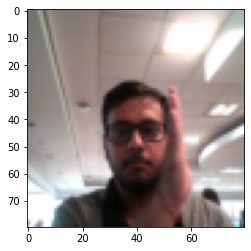

In [ ]:
#Plotting the resized image
plt.imshow(img_resized)
plt.show()

## Model
We're experimenting with various Keras functionalities to build models. Specifically, we're utilizing 3D convolutional networks, where the third dimension represents the frames in a video's time series. The final layer employs softmax for a 5-class classification task. Our goal is to develop a model with high accuracy while minimizing the number of parameters, enabling it to run efficiently within the memory constraints of a webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

2024-05-06 08:41:39.600950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:41:39.601048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:41:39.768652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
from keras.layers import TimeDistributed, Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.regularizers import l1

In [ ]:
#defining a sequential CNN model
model1 = Sequential()

# Model architecture
model1.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.3))
model1.add(Dense(5))
model1.add(Activation('softmax'))

In [ ]:
## Compiling the model
optimiser = 'adam'
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_3 (Conv3D)           (None, 22, 120, 120, 32)  2624      

                                                                 

 activation_4 (Activation)   (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d_3 (MaxPooling  (None, 11, 60, 60, 32)   0         

 3D)                                                             

                                                                 

 conv3d_4 (Conv3D)           (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_5 (Activation)   (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_4 (MaxPooling  (None, 5, 30, 30, 64)    0         

 3D)                                  

#### Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 10

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)


# Final image size: 120

# Batch Size: 10

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


Defining early stops, call backs, learning rate plateau, model name to be saved

In [10]:
# Define the ReduceLROnPlateau callback to adjust learning rate
LR = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                       factor=0.2,
                       patience=5,
                       min_lr=0.0001)  # If no improvement in accuracy for 5 epochs, reduce LR by 0.2

# Define the EarlyStopping callback to halt training if no improvement in accuracy
earlystop = EarlyStopping(monitor="val_categorical_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)  # Stop training if no improvement for 5 epochs

# Create a list of callbacks
callbacks_list = [LR, earlystop]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model1_history = model1.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/2363790828.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model1_history = model1.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 10

Epoch 1/20


2024-05-01 09:34:56.909885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


65/67 [============================>.] - ETA: 3s - loss: 1.6592 - categorical_accuracy: 0.2400Batch:  67 Index: 10 Remaining data code

67/67 [==============================] - ETA: 0s - loss: 1.6584 - categorical_accuracy: 0.2459Source path =  /datasets/Project_data/val ; batch size = 10

67/67 [==============================] - 121s 2s/step - loss: 1.6584 - categorical_accuracy: 0.2459 - val_loss: 1.4598 - val_categorical_accuracy: 0.3100 - lr: 0.0010

Epoch 2/20

67/67 [==============================] - 44s 665ms/step - loss: 1.4324 - categorical_accuracy: 0.3682 - val_loss: 1.4684 - val_categorical_accuracy: 0.3100 - lr: 0.0010

Epoch 5/20

67/67 [==============================] - 46s 692ms/step - loss: 1.3638 - categorical_accuracy: 0.4229 - val_loss: 1.2138 - val_categorical_accuracy: 0.5300 - lr: 0.0010

Epoch 6/20

67/67 [==============================] - 45s 678ms/step - loss: 1.3597 - categorical_accuracy: 0.3582 - val_loss: 1.3211 - val_categorical_accuracy: 0.3300 - lr: 0.0

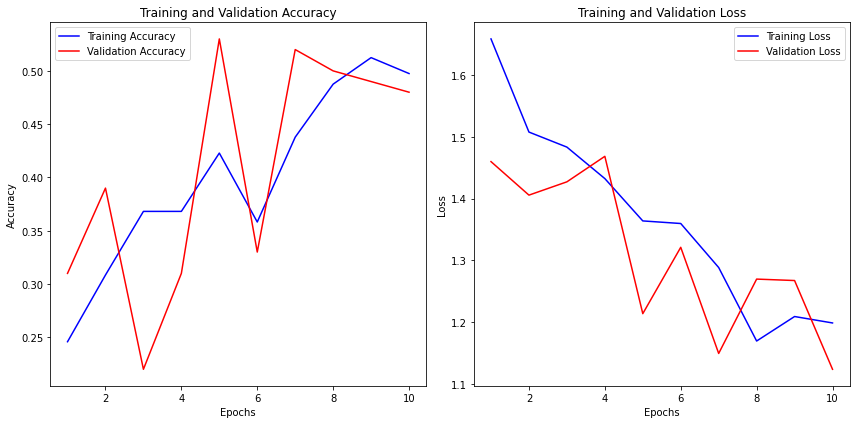

In [ ]:
plot_graph(model1_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model1_history.history['val_categorical_accuracy'].index(max(model1_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model1_val_acc = max(model1_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model1_trg_acc = model1_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model1_params = model1.count_params()

# Print the results
print("Max validation accuracy:", model1_val_acc)
print("Corresponding training accuracy:", model1_trg_acc)
print("Number of parameters:", model1_params)

Max validation accuracy: 0.5299999713897705

Corresponding training accuracy: 0.42288556694984436

Number of parameters: 7652869


### Observation:
The training and validation accuracies are quite low.

### Experiment 2: Model 2

Increaing the batch size from 10 to 15 keeping the rest of the properties for images size and images indices the same as model 1

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 15

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 15

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model2 = Sequential()

# Model architecture
model2.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(5))
model2.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_5"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_9 (Conv3D)           (None, 22, 120, 120, 32)  2624      

                                                                 

 activation_14 (Activation)  (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d_9 (MaxPooling  (None, 11, 60, 60, 32)   0         

 3D)                                                             

                                                                 

 conv3d_10 (Conv3D)          (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_15 (Activation)  (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_10 (MaxPoolin  (None, 5, 30, 30, 64)    0         

 g3D)                                 

In [ ]:
model2_history = model2.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/3402054644.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model2_history = model2.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 15

Epoch 1/20

43/45 [===========================>..] - ETA: 6s - loss: 1.7499 - categorical_accuracy: 0.2279Batch:  45 Index: 15 Remaining data code

45/45 [==============================] - ETA: 0s - loss: 1.7402 - categorical_accuracy: 0.2293Source path =  /datasets/Project_data/val ; batch size = 15

Batch:  7 Index: 15 Remaining data code

45/45 [==============================] - 163s 4s/step - loss: 1.7402 - categorical_accuracy: 0.2293 - val_loss: 1.5272 - val_categorical_accuracy: 0.2600 - lr: 0.0010

Epoch 2/20

45/45 [==============================] - 34s 764ms/step - loss: 1.5578 - categorical_accuracy: 0.2444 - val_loss: 1.4410 - val_categorical_accuracy: 0.4571 - lr: 0.0010

Epoch 3/20

45/45 [==============================] - 35s 802ms/step - loss: 1.5910 - categorical_accuracy: 0.3778 - val_loss: 1.4128 - val_categorical_accuracy: 0.4143 - lr: 0.0010

Epoch 4/20

45/45 [==============================] - 34s 771m

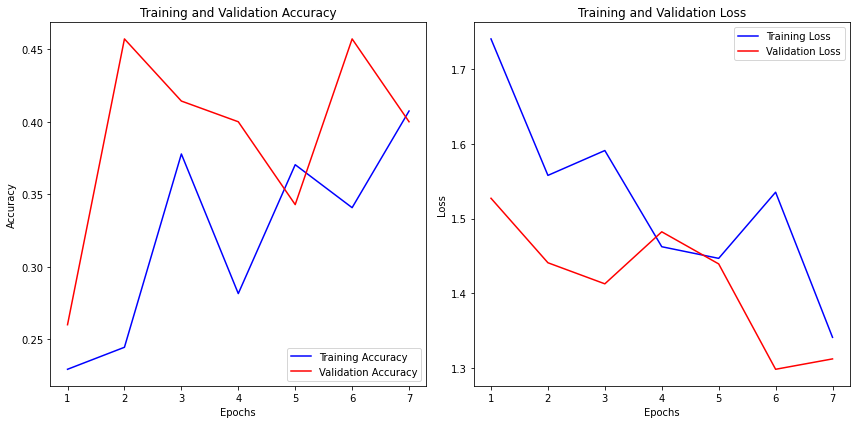

In [ ]:
plot_graph(model2_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model2_history.history['val_categorical_accuracy'].index(max(model2_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model2_val_acc = max(model2_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model2_trg_acc = model2_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model2_params = model2.count_params()

# Print the results
print("Max validation accuracy:", model2_val_acc)
print("Corresponding training accuracy:", model2_trg_acc)
print("Number of parameters:", model2_params)

Max validation accuracy: 0.4571428596973419

Corresponding training accuracy: 0.24444444477558136

Number of parameters: 7652869


#### Observation: The train and validation accuracies have gone down.

### Experiment 3: Model 3

Increasing batch size with full range of images and adding one more dense layer

In [31]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120
# Batch Size: 32
# Length of image index: 22
# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model3 = Sequential()

# Model architecture
model3.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Flatten())
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(5))
model3.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_6"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_12 (Conv3D)          (None, 22, 120, 120, 32)  2624      

                                                                 

 activation_19 (Activation)  (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d_12 (MaxPoolin  (None, 11, 60, 60, 32)   0         

 g3D)                                                            

                                                                 

 conv3d_13 (Conv3D)          (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_20 (Activation)  (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_13 (MaxPoolin  (None, 5, 30, 30, 64)    0         

 g3D)                                 

In [ ]:
model3_history = model3.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/3712908193.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model3_history = model3.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20

19/21 [==========================>...] - ETA: 8s - loss: 1.6815 - categorical_accuracy: 0.2220 Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.6740 - categorical_accuracy: 0.2247Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 108s 5s/step - loss: 1.6740 - categorical_accuracy: 0.2247 - val_loss: 1.5720 - val_categorical_accuracy: 0.2900 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 65s 3s/step - loss: 1.5527 - categorical_accuracy: 0.2816 - val_loss: 1.4261 - val_categorical_accuracy: 0.3750 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 53s - loss: 1.4789 - categorical_accuracy: 0.3043Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 63s 3s/step - loss: 1.4639 - categorical_accuracy: 0.37

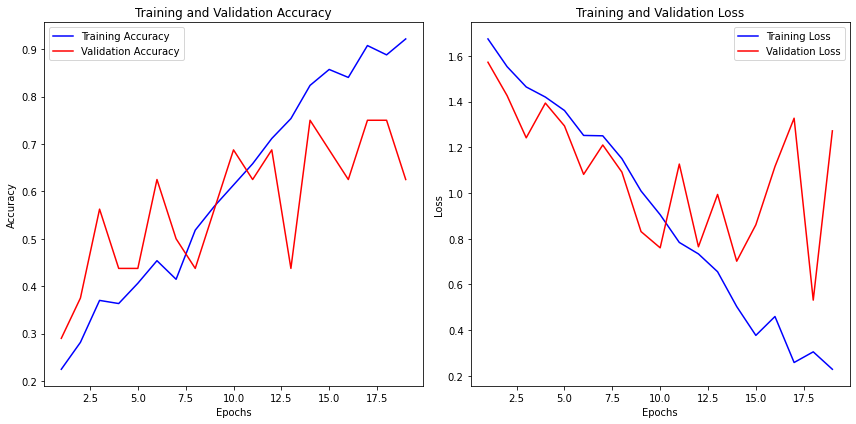

In [ ]:
plot_graph(model3_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model3_history.history['val_categorical_accuracy'].index(max(model3_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model3_val_acc = max(model3_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model3_trg_acc = model3_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model3_params = model3.count_params()

# Print the results
print("Max validation accuracy:", model3_val_acc)
print("Corresponding training accuracy:", model3_trg_acc)
print("Number of parameters:", model3_params)

Max validation accuracy: 0.75

Corresponding training accuracy: 0.8235294222831726

Number of parameters: 3974725


#### Observation: The training accuracy has gone up as well as the validation accuracy but we can clearly see some overfitting.


### Experiment 4: Model 4

keeping bacth size and imsage size and the image indices range all the same. However, modifying the model architecture by reducing the number of neurons and adding a dropout layer after the dense layer.

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
## defining a sequential CNN model
model4 = Sequential()

# Model architecture
model4.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Flatten())
model4.add(Dense(64))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))

model4.add(Dense(5))
model4.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_10"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_24 (Conv3D)          (None, 22, 120, 120, 16)  1312      

                                                                 

 activation_40 (Activation)  (None, 22, 120, 120, 16)  0         

                                                                 

 max_pooling3d_24 (MaxPoolin  (None, 11, 60, 60, 16)   0         

 g3D)                                                            

                                                                 

 conv3d_25 (Conv3D)          (None, 11, 60, 60, 32)    13856     

                                                                 

 activation_41 (Activation)  (None, 11, 60, 60, 32)    0         

                                                                 

 max_pooling3d_25 (MaxPoolin  (None, 5, 30, 30, 32)    0         

 g3D)                                

In [ ]:
model4_history = model4.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/874038354.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model4_history = model4.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20

19/21 [==========================>...] - ETA: 8s - loss: 1.6527 - categorical_accuracy: 0.2138 Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.6498 - categorical_accuracy: 0.2142Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 106s 5s/step - loss: 1.6498 - categorical_accuracy: 0.2142 - val_loss: 1.5922 - val_categorical_accuracy: 0.2300 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 68s 3s/step - loss: 1.5945 - categorical_accuracy: 0.2277 - val_loss: 1.5405 - val_categorical_accuracy: 0.2500 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 51s - loss: 1.5563 - categorical_accuracy: 0.1739Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 63s 3s/step - loss: 1.5302 - categorical_accuracy: 0.23

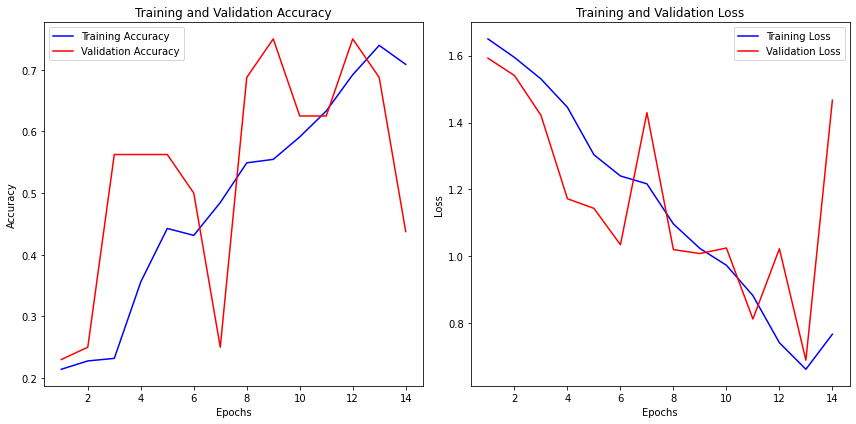

In [ ]:
plot_graph(model4_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model4_history.history['val_categorical_accuracy'].index(max(model4_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model4_val_acc = max(model4_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model4_trg_acc = model4_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model4_params = model4.count_params()

# Print the results
print("Max validation accuracy:", model4_val_acc)
print("Corresponding training accuracy:", model4_trg_acc)
print("Number of parameters:", model4_params)

Max validation accuracy: 0.75

Corresponding training accuracy: 0.5546218752861023

Number of parameters: 1914117


### Observation:


### Experiment 5: Model 5

Going back to model 3 which seems promising. The only changes that will be made more adding dropout layers after every convolutional layer to handle the overfiting

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model5 = Sequential()

# Model architecture
model5.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Flatten())
model5.add(Dense(64))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))
model5.add(Dense(128))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))
model5.add(Dense(5))
model5.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_14"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_36 (Conv3D)          (None, 22, 120, 120, 32)  2624      

                                                                 

 activation_63 (Activation)  (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d_36 (MaxPoolin  (None, 11, 60, 60, 32)   0         

 g3D)                                                            

                                                                 

 dropout_22 (Dropout)        (None, 11, 60, 60, 32)    0         

                                                                 

 conv3d_37 (Conv3D)          (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_64 (Activation)  (None, 11, 60, 60, 64)    0         

                                     

In [ ]:
model5_history = model5.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/192434988.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model5_history = model5.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20

19/21 [==========================>...] - ETA: 12s - loss: 1.8720 - categorical_accuracy: 0.1743Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.8493 - categorical_accuracy: 0.1931Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 143s 7s/step - loss: 1.8493 - categorical_accuracy: 0.1931 - val_loss: 1.6043 - val_categorical_accuracy: 0.3900 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 83s 4s/step - loss: 1.6042 - categorical_accuracy: 0.2340 - val_loss: 1.5956 - val_categorical_accuracy: 0.5000 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 1:03 - loss: 1.5975 - categorical_accuracy: 0.2681Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 66s 3s/step - loss: 1.5843 - categorical_accuracy: 0.2

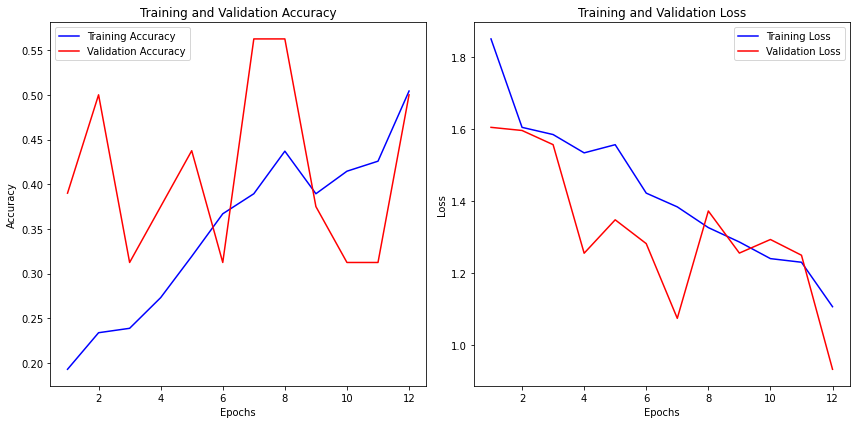

In [ ]:
plot_graph(model5_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model5_history.history['val_categorical_accuracy'].index(max(model5_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model5_val_acc = max(model5_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model5_trg_acc = model5_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model5_params = model5.count_params()

# Print the results
print("Max validation accuracy:", model5_val_acc)
print("Corresponding training accuracy:", model5_trg_acc)
print("Number of parameters:", model5_params)


Max validation accuracy: 0.5625

Corresponding training accuracy: 0.38935574889183044

Number of parameters: 3974725


### Observation:

### Experiment 6: Model 6

Reducing the number of image indices and changing the model architecture to conv2D and adding a GRU layer

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model6 = Sequential()

# Define the input shape for the first layer
model6.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(len(img_idx), 120, 120, 3)))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(TimeDistributed(GlobalAveragePooling2D()))
model6.add(TimeDistributed(Dense(64, activation='relu')))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(GRU(128))
model6.add(BatchNormalization())

model6.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = 'adam'
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_14"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_51 (TimeDi  (None, 15, 118, 118, 32)  896      

 stributed)                                                      

                                                                 

 time_distributed_52 (TimeDi  (None, 15, 59, 59, 32)   0         

 stributed)                                                      

                                                                 

 batch_normalization (BatchN  (None, 15, 59, 59, 32)   128       

 ormalization)                                                   

                                                                 

 dropout_8 (Dropout)         (None, 15, 59, 59, 32)    0         

                                                                 

 time_distributed_53 (TimeDi  (None, 15, 57, 57, 64)   18496     

 stributed)                          

In [ ]:
model6_history = model6.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_208/604441966.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model6_history = model6.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20

14/21 [===================>..........] - ETA: 22s - loss: 1.4409 - categorical_accuracy: 0.4420Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.4011 - categorical_accuracy: 0.4579Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 74s 4s/step - loss: 1.4011 - categorical_accuracy: 0.4579 - val_loss: 1.6090 - val_categorical_accuracy: 0.1800 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 46s 2s/step - loss: 1.2053 - categorical_accuracy: 0.5238 - val_loss: 1.6126 - val_categorical_accuracy: 0.1250 - lr: 0.0010

Epoch 3/20

 1/21 [>.............................] - ETA: 2s - loss: 1.2165 - categorical_accuracy: 0.4348Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 37s 2s/step - loss: 1.0334 - categorical_accuracy: 0.5553 - val_loss: 1.5896 - val_categorical_accuracy: 0.3750 - lr: 0.

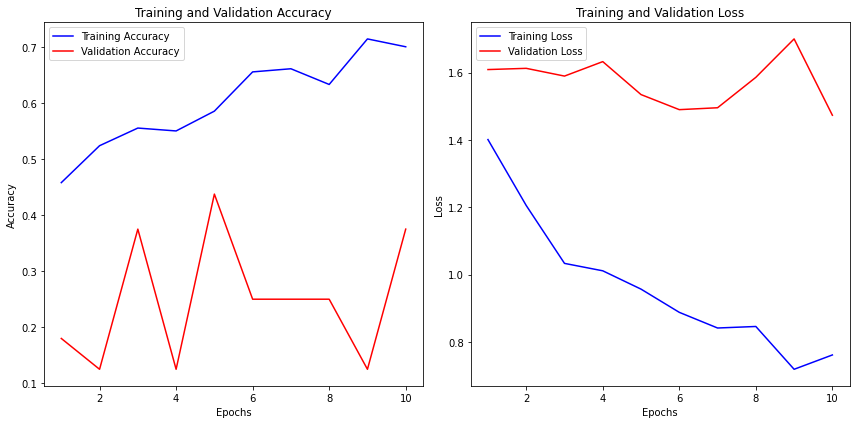

In [ ]:
plot_graph(model6_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model6_history.history['val_categorical_accuracy'].index(max(model6_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model6_val_acc = max(model6_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model6_trg_acc = model6_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model6_params = model6.count_params()

# Print the results
print("Max validation accuracy:", model6_val_acc)
print("Corresponding training accuracy:", model6_trg_acc)
print("Number of parameters:", model6_params)

Maximum validation accuracy: 0.5277777910232544

Corresponding training accuracy: 0.3154761791229248

Corresponding number of parameters: 502661


### Observation: Very poor performance.


### Experiment 7: Model 7

Applying transfer learning by using MobileNet and GRU which combines efficient feature extraction with sequential processing, allowing for effective analysis of temporal data patterns. This approach optimizes computational resources while capturing nuanced gestures for accurate recognition.

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [11]:
from keras.applications.mobilenet import MobileNet

In [12]:
# Load MobileNet model without top layers
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze MobileNet layers
for layer in mobilenet_base.layers:
    layer.trainable = False

/tmp/ipykernel_34/4271448225.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(120, 120, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create your model
model7 = Sequential()

# Add MobileNet base to the model
model7.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))

# Add pooling layer
model7.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model7.add(TimeDistributed(Flatten()))
model7.add(GRU(128))
model7.add(BatchNormalization())
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_17"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_71 (TimeDi  (None, 15, 3, 3, 1024)   3228864   

 stributed)                                                      

                                                                 

 time_distributed_72 (TimeDi  (None, 15, 1, 1, 1024)   0         

 stributed)                                                      

                                                                 

 time_distributed_73 (TimeDi  (None, 15, 1024)         0         

 stributed)                                                      

                                                                 

 gru_10 (GRU)                (None, 128)               443136    

                                                                 

 batch_normalization_6 (Batc  (None, 128)              512       

 hNormalization)                     

In [ ]:
model7_history = model7.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_208/3032491426.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model7_history = model7.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20

21/21 [==============================] - 39s 2s/step - loss: 1.6454 - categorical_accuracy: 0.3137 - val_loss: 1.5320 - val_categorical_accuracy: 0.3750 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 35s 2s/step - loss: 1.4416 - categorical_accuracy: 0.4286 - val_loss: 1.4043 - val_categorical_accuracy: 0.4375 - lr: 0.0010

Epoch 3/20

21/21 [==============================] - 36s 2s/step - loss: 1.2082 - categorical_accuracy: 0.5322 - val_loss: 1.2530 - val_categorical_accuracy: 0.4375 - lr: 0.0010

Epoch 4/20

21/21 [==============================] - 36s 2s/step - loss: 1.0576 - categorical_accuracy: 0.6162 - val_loss: 1.0184 - val_categorical_accuracy: 0.5625 - lr: 0.0010

Epoch 5/20

21/21 [==============================] - 35s 2s/step - loss: 0.7724 - categorical_accuracy: 0.7451 - val_loss: 1.0764 - val_categorical_accuracy: 0.5625 - lr: 0.0010

Epoch 6/20

21/21 [==============================] - 36s 2s/step - loss: 0.6927 - categorical_accuracy: 0

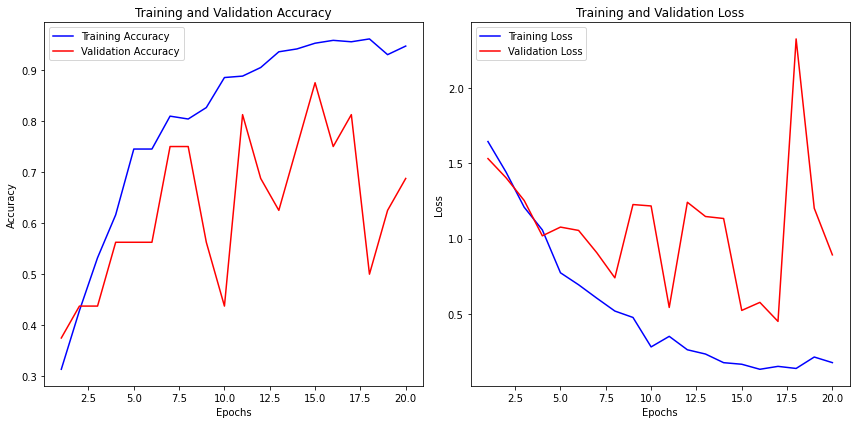

In [ ]:
plot_graph(model7_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model7_history.history['val_categorical_accuracy'].index(max(model7_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model7_val_acc = max(model7_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model7_trg_acc = model7_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model7_params = model7.count_params()

# Print the results
print("Max validation accuracy:", model7_val_acc)
print("Corresponding training accuracy:", model7_trg_acc)
print("Number of parameters:", model7_params)

Max validation accuracy: 0.875

Corresponding training accuracy: 0.9523809552192688

Number of parameters: 3689733


### Observation:
Good training and validation accuracy scores but overfiting present.

### Experiment 8: Model 8

Using the base model architecture as model 3 but this time chaning the dropout from 0.3 to 0.5.

In [ ]:
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
image_indices = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(image_indices))
print('# Image indices to be considered:', image_indices)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, image_indices, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, image_indices, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model8 = Sequential()

# Model architecture
model8.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))


model8.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Flatten())
model8.add(Dense(64))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(Dense(128))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(Dense(5))
model8.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d (Conv3D)             (None, 22, 120, 120, 32)  2624      

                                                                 

 activation (Activation)     (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d (MaxPooling3D  (None, 11, 60, 60, 32)   0         

 )                                                               

                                                                 

 conv3d_1 (Conv3D)           (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_1 (Activation)   (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_1 (MaxPooling  (None, 5, 30, 30, 64)    0         

 3D)                                  

In [ ]:
model8_history = model8.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/tmp/ipykernel_847/2314245963.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model8_history = model8.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20


2024-05-01 14:05:18.735685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/21 [==========================>...] - ETA: 8s - loss: 1.7500 - categorical_accuracy: 0.2122 Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.7396 - categorical_accuracy: 0.2157Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 106s 5s/step - loss: 1.7396 - categorical_accuracy: 0.2157 - val_loss: 1.5604 - val_categorical_accuracy: 0.3400 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 67s 3s/step - loss: 1.5805 - categorical_accuracy: 0.2795 - val_loss: 1.5827 - val_categorical_accuracy: 0.4375 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 47s - loss: 1.5980 - categorical_accuracy: 0.2536Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 57s 3s/step - loss: 1.5518 - categorical_accuracy: 0.3326 - val_loss: 1.3821 - val_categorical_accuracy: 0.3750 - lr: 0.0010

Epoc

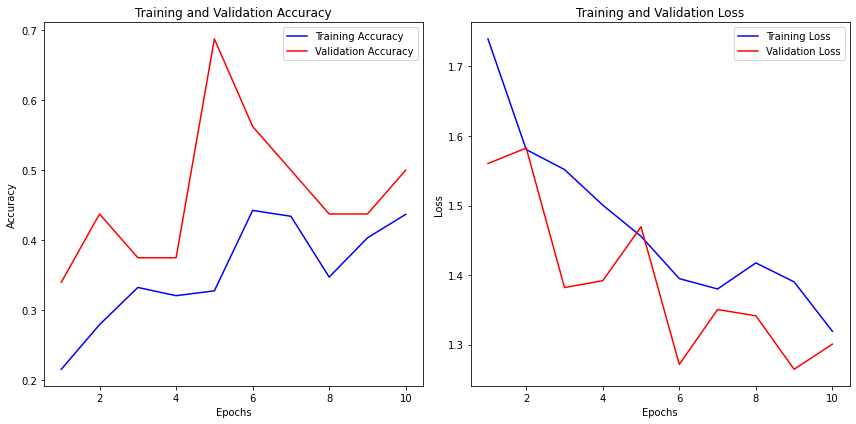

In [ ]:
plot_graph(model8_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model8_history.history['val_categorical_accuracy'].index(max(model8_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model8_val_acc = max(model8_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model8_trg_acc = model8_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model8_params = model8.count_params()

# Print the results
print("Max validation accuracy:", model8_val_acc)
print("Corresponding training accuracy:", model8_trg_acc)
print("Number of parameters:", model8_params)


Max validation accuracy: 0.6875

Corresponding training accuracy: 0.32773110270500183

Number of parameters: 3974725


### Observation
Did not reduce overfitting instead lowered training accuracy.


### Experiment 9

Chaning the dropout values back to 0.3 and reducing the batch size from 32 to 8. Keeping the rest same

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 8

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = list(range(1, 23))  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 8

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model9 = Sequential()

# Model architecture
model9.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', input_shape=(len(img_idx), 120, 120, 3)))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(filters=128, kernel_size=(3, 3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Flatten())
model9.add(Dense(64))
model9.add(Activation('relu'))
model9.add(Dropout(0.3))
model9.add(Dense(128))
model9.add(Activation('relu'))
model9.add(Dropout(0.3))
model9.add(Dense(5))
model9.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_10"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_28 (Conv3D)          (None, 22, 120, 120, 32)  2624      

                                                                 

 activation_34 (Activation)  (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d_28 (MaxPoolin  (None, 11, 60, 60, 32)   0         

 g3D)                                                            

                                                                 

 conv3d_29 (Conv3D)          (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_35 (Activation)  (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_29 (MaxPoolin  (None, 5, 30, 30, 64)    0         

 g3D)                                

In [ ]:
model9_history = model9.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/3479583896.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model9_history = model9.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 8

Epoch 1/20

81/83 [============================>.] - ETA: 2s - loss: 1.6184 - categorical_accuracy: 0.2130Batch:  83 Index: 8 Remaining data code

83/83 [==============================] - ETA: 0s - loss: 1.6172 - categorical_accuracy: 0.2157Source path =  /datasets/Project_data/val ; batch size = 8

Batch:  13 Index: 8 Remaining data code

83/83 [==============================] - 118s 1s/step - loss: 1.6172 - categorical_accuracy: 0.2157 - val_loss: 1.4919 - val_categorical_accuracy: 0.2400 - lr: 0.0010

Epoch 2/20

83/83 [==============================] - 94s 1s/step - loss: 1.5998 - categorical_accuracy: 0.1979 - val_loss: 1.5704 - val_categorical_accuracy: 0.1923 - lr: 0.0010

Epoch 3/20

10/83 [==>...........................] - ETA: 1:24 - loss: 1.5451 - categorical_accuracy: 0.3143Batch:  95 Index: 7 Remaining data code

83/83 [==============================] - 75s 912ms/step - loss: 1.5418 - categorical_accuracy: 0.320

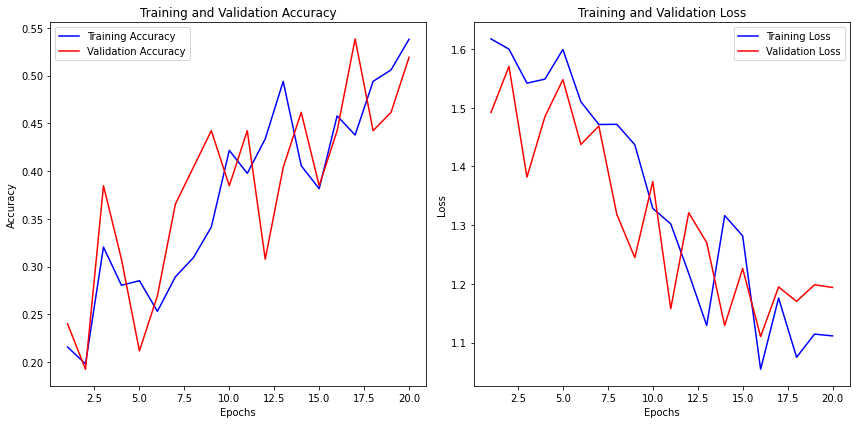

In [ ]:
plot_graph(model9_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model9_history.history['val_categorical_accuracy'].index(max(model9_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model9_val_acc = max(model9_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model9_trg_acc = model9_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model9_params = model9.count_params()

# Print the results
print("Max validation accuracy:", model9_val_acc)
print("Corresponding training accuracy:", model9_trg_acc)
print("Number of parameters:", model9_params)


Max validation accuracy: 0.5384615659713745

Corresponding training accuracy: 0.43775099515914917

Number of parameters: 3974725


### Observation
There is no overfitting but both the train and validation accuracy can be better.


### Experiment 10: Model 10

This time we will apply l2 regularization on the base model 3 (with batch size= 32, image index = 1 to 22) and see if the accuracy of both the train and validation can be maintained while the overfitting problem is handled.

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 22

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
from keras import regularizers

In [ ]:
#defining a sequential CNN model
model10 = Sequential()

# Model architecture
model10.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', input_shape=(len(img_idx), 120, 120, 3)))
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(filters=128, kernel_size=(3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001))) #Added L2 regularizer
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Flatten())
model10.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model10.add(Dropout(0.3))
model10.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model10.add(Dense(5, activation='softmax'))

2024-05-04 11:08:26.658126: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2024-05-04 11:08:26.658192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [ ]:
optimizer = 'adam'#write your optimizer
model10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d (Conv3D)             (None, 22, 120, 120, 32)  2624      

                                                                 

 activation (Activation)     (None, 22, 120, 120, 32)  0         

                                                                 

 max_pooling3d (MaxPooling3D  (None, 11, 60, 60, 32)   0         

 )                                                               

                                                                 

 conv3d_1 (Conv3D)           (None, 11, 60, 60, 64)    55360     

                                                                 

 activation_1 (Activation)   (None, 11, 60, 60, 64)    0         

                                                                 

 max_pooling3d_1 (MaxPooling  (None, 5, 30, 30, 64)    0         

 3D)                                    

In [ ]:
# Define the ReduceLROnPlateau callback to adjust learning rate
LR = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                       factor=0.2,
                       patience=5,
                       min_lr=0.0001)  # If no improvement in accuracy for 5 epochs, reduce LR by 0.2

# Define the EarlyStopping callback to halt training if no improvement in accuracy
earlystop = EarlyStopping(monitor="val_categorical_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)  # Stop training if no improvement for 5 epochs

# Create a list of callbacks
callbacks_list = [LR, earlystop]

In [ ]:
model10_history = model10.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/3215623786.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model10_history = model10.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20


2024-05-04 11:09:09.775626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/21 [==========================>...] - ETA: 17s - loss: 1.7178 - categorical_accuracy: 0.1924Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.7061 - categorical_accuracy: 0.1961Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 211s 10s/step - loss: 1.7061 - categorical_accuracy: 0.1961 - val_loss: 1.5481 - val_categorical_accuracy: 0.3500 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 122s 6s/step - loss: 1.5086 - categorical_accuracy: 0.3478 - val_loss: 1.4259 - val_categorical_accuracy: 0.4375 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 1:32 - loss: 1.5951 - categorical_accuracy: 0.3116Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 98s 5s/step - loss: 1.5125 - categorical_accuracy: 0.3700 - val_loss: 1.3325 - val_categorical_accuracy: 0.3750 - lr: 0.0010

E

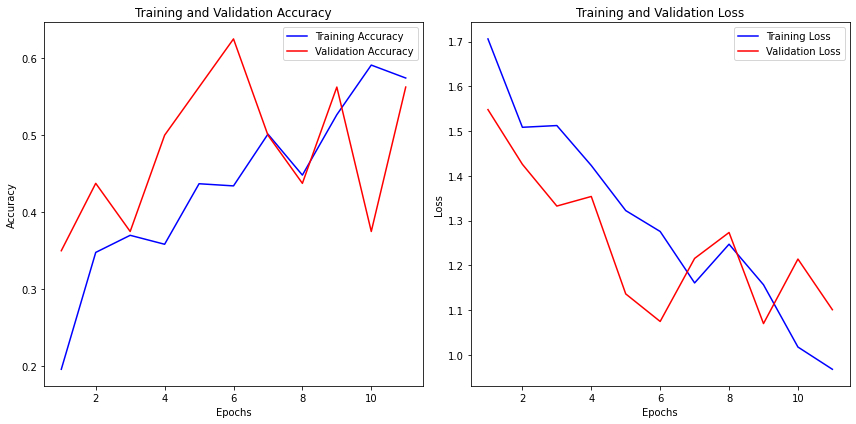

In [ ]:
plot_graph(model10_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model10_history.history['val_categorical_accuracy'].index(max(model10_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model10_val_acc = max(model10_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model10_trg_acc = model10_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model10_params = model10.count_params()

# Print the results
print("Max validation accuracy:", model10_val_acc)
print("Corresponding training accuracy:", model10_trg_acc)
print("Number of parameters:", model10_params)

Max validation accuracy: 0.625

Corresponding training accuracy: 0.43417367339134216

Number of parameters: 3974725


### Observation:
The L2 regularisation seems to be too aggressive even at 0.0001 and the validation accuracy is more than the training.

### Experiment 11: Model 11

This time changing the architecture of the model to model architecture of model 7 with the transfer learning mobilenet and adding a GRU layer with dropout layer of 0.3. Batch size = 32 and image index = 1 to 23. Also applying L1 regularisation of strength 0.01.

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22, 23]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 23

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
from keras.regularizers import l1

# Create your model
model11 = Sequential()

# Add MobileNet base to the model
model11.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))
model11.add(TimeDistributed(BatchNormalization()))
# Add pooling layer
model11.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model11.add(TimeDistributed(Flatten()))
model11.add(GRU(128))
model11.add(BatchNormalization())
model11.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01))) # Adding L1 regularization
model11.add(Dropout(0.3))
model11.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01))) # Adding L1 regularization
model11.add(Dropout(0.3))
model11.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model11.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed (TimeDistr  (None, 23, 3, 3, 1024)   3228864   

 ibuted)                                                         

                                                                 

 time_distributed_1 (TimeDis  (None, 23, 3, 3, 1024)   4096      

 tributed)                                                       

                                                                 

 time_distributed_2 (TimeDis  (None, 23, 1, 1, 1024)   0         

 tributed)                                                       

                                                                 

 time_distributed_3 (TimeDis  (None, 23, 1024)         0         

 tributed)                                                       

                                                                 

 gru (GRU)                   (None, 128)

In [ ]:
model11_history = model11.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_370/129431019.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model11_history = model11.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20


2024-05-05 08:42:22.557582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/21 [==========================>...] - ETA: 8s - loss: 15.2318 - categorical_accuracy: 0.3109 Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 15.1254 - categorical_accuracy: 0.3258Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 113s 5s/step - loss: 15.1254 - categorical_accuracy: 0.3258 - val_loss: 14.0532 - val_categorical_accuracy: 0.2900 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 72s 4s/step - loss: 12.7740 - categorical_accuracy: 0.6294 - val_loss: 12.1827 - val_categorical_accuracy: 0.5625 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 50s - loss: 11.5559 - categorical_accuracy: 0.7391Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 61s 3s/step - loss: 10.9365 - categorical_accuracy: 0.7658 - val_loss: 10.3569 - val_categorical_accuracy: 0.5625 - lr: 0.0

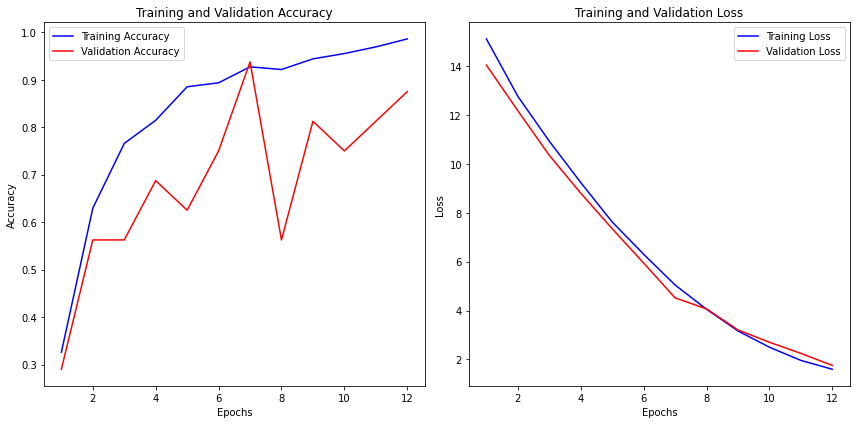

In [ ]:
plot_graph(model11_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model11_history.history['val_categorical_accuracy'].index(max(model11_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model11_val_acc = max(model11_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model11_trg_acc = model11_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model11_params = model11.count_params()

# Print the results
print("Max validation accuracy:", model11_val_acc)
print("Corresponding training accuracy:", model11_trg_acc)
print("Number of parameters:", model11_params)

Max validation accuracy: 0.9375

Corresponding training accuracy: 0.9271708726882935

Number of parameters: 3693829


### Observation:
This model demonstrates impressive performance, achieving a categorical accuracy of approximately 98.60% on the training set and 87.50% on the validation set, with corresponding losses of approximately 1.5932 and 1.7516, respectively. The model shows signs of overfitting, as evidenced by the higher accuracy on the training set compared to the validation set and the early stopping after 12 epochs.

### Experiment 12 : Model 12

This time reducing the batch size to 10 and removing one of the dense layer(64) with learning rate of 0.0001.   

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 10

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

This time reducing the batch size to 10 and removing one of the dense layer(64) with learning rate of 0.0001.

In [ ]:
# Create your model
model12 = Sequential()

# Add MobileNet base to the model
model12.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))
model12.add(TimeDistributed(BatchNormalization()))
# Add pooling layer
model12.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model12.add(TimeDistributed(Flatten()))
model12.add(GRU(128))
model12.add(Dropout(0.3))

model12.add(Dense(128, activation='relu'))
model12.add(Dropout(0.3))
model12.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model12.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_7"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   

 tributed)                                                       

                                                                 

 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      

 tributed)                                                       

                                                                 

 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         

 tributed)                                                       

                                                                 

 time_distributed_7 (TimeDis  (None, 20, 1024)         0         

 tributed)                                                       

                                                                 

 gru_1 (GRU)                 (None, 12

In [ ]:
model12_history = model12.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_847/2262134972.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model12_history = model12.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20

67/67 [==============================] - 44s 628ms/step - loss: 1.6792 - categorical_accuracy: 0.2438 - val_loss: 1.2004 - val_categorical_accuracy: 0.5800 - lr: 0.0010

Epoch 2/20

67/67 [==============================] - 40s 601ms/step - loss: 1.4337 - categorical_accuracy: 0.4279 - val_loss: 1.1172 - val_categorical_accuracy: 0.5300 - lr: 0.0010

Epoch 3/20

67/67 [==============================] - 41s 626ms/step - loss: 1.2763 - categorical_accuracy: 0.4726 - val_loss: 1.0851 - val_categorical_accuracy: 0.5500 - lr: 0.0010

Epoch 4/20

67/67 [==============================] - 43s 652ms/step - loss: 1.1549 - categorical_accuracy: 0.5323 - val_loss: 0.9185 - val_categorical_accuracy: 0.6400 - lr: 0.0010

Epoch 5/20

67/67 [==============================] - 40s 600ms/step - loss: 1.0202 - categorical_accuracy: 0.5821 - val_loss: 0.8605 - val_categorical_accuracy: 0.6700 - lr: 0.0010

Epoch 6/20

67/67 [==============================] - 79s 1s/step - loss: 0.8465 - categori

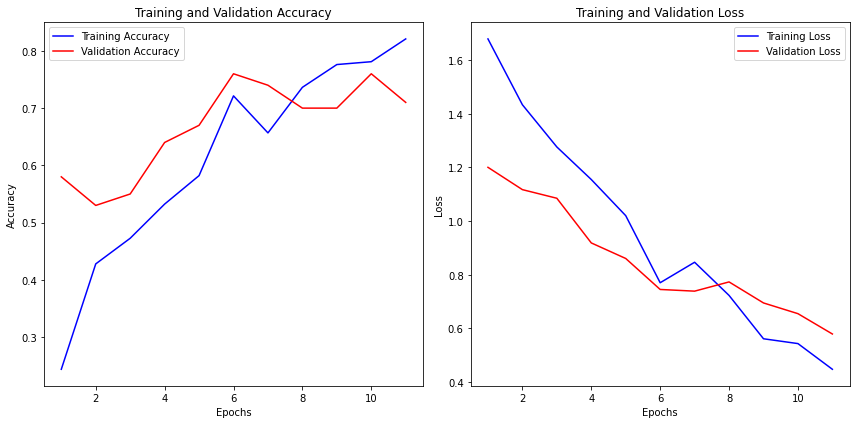

In [ ]:
plot_graph(model12_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model12_history.history['val_categorical_accuracy'].index(max(model12_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model12_val_acc = max(model12_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model12_trg_acc = model12_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model12_params = model12.count_params()

# Print the results
print("Max validation accuracy:", model12_val_acc)
print("Corresponding training accuracy:", model12_trg_acc)
print("Number of parameters:", model12_params)


Max validation accuracy: 0.7599999904632568

Corresponding training accuracy: 0.7213930487632751

Number of parameters: 3693253


### Observation:
No concerning overfitting observed and the scores of both training and validation are decent. Only concern being that the validation score is slightly better than training.


### Experiment 13: Model 13

This time changing image index range from 1 to 23. Also keeping the strength of l2 regularisation at 0.025 and the dropout layers to 0.2.

In [38]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22, 23]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120
# Batch Size: 32
# Length of image index: 23
# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
# Define the ReduceLROnPlateau callback to adjust learning rate
LR = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                       factor=0.2,
                       patience=5,
                       min_lr=0.0001)  # If no improvement in accuracy for 5 epochs, reduce LR by 0.2

# Define the EarlyStopping callback to halt training if no improvement in accuracy
earlystop = EarlyStopping(monitor="val_categorical_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)  # Stop training if no improvement for 5 epochs

# Create a list of callbacks
callbacks_list = [LR, earlystop]

In [16]:
# Create your model
model13 = Sequential()

# Add MobileNet base to the model
model13.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))
model13.add(TimeDistributed(BatchNormalization()))
# Add pooling layer
model13.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model13.add(TimeDistributed(Flatten()))
model13.add(GRU(128))
model13.add(BatchNormalization())
model13.add(Dense(64, activation='relu', kernel_regularizer=l1(0.025))) # Adding L1 regularization
model13.add(Dropout(0.2))
model13.add(Dense(128, activation='relu', kernel_regularizer=l1(0.025))) # Adding L1 regularization
model13.add(Dropout(0.2))
model13.add(Dense(5, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
optimizer = 'adam'#write your optimizer
model13.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │         4,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │       443,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,693,829 (14.09 MB)

 Trainable params: 462,661 (1.76 MB)

 Non-trainable params: 3,231,168 (12.33 MB)

None


In [21]:
model13_history = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/train ; batch size = 32
Epoch 1/20
19/21 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - categorical_accuracy: 0.2534 - loss: 36.3857Batch:  21 Index: 32 Remaining data code
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2608 - loss: 36.2044Source path =  /kaggle/input/gesture-recognition/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code
21/21 ━━━━━━━━━━━━━━━━━━━━ 256s 10s/step - categorical_accuracy: 0.2643 - loss: 36.1229 - val_categorical_accuracy: 0.6000 - val_loss: 30.4613 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - categorical_accuracy: 0.6507 - loss: 28.6061 - val_categorical_accuracy: 0.5625 - val_loss: 23.9838 - learning_rate: 0.0010
Epoch 3/20
20/21 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - categorical_accuracy: 0.8447 - loss: 16.8831Batch:  35 Index: 19 Remaining data code
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - categorical_accuracy: 0.8442 - loss: 16.7734 - val_categorical_accuracy: 0.

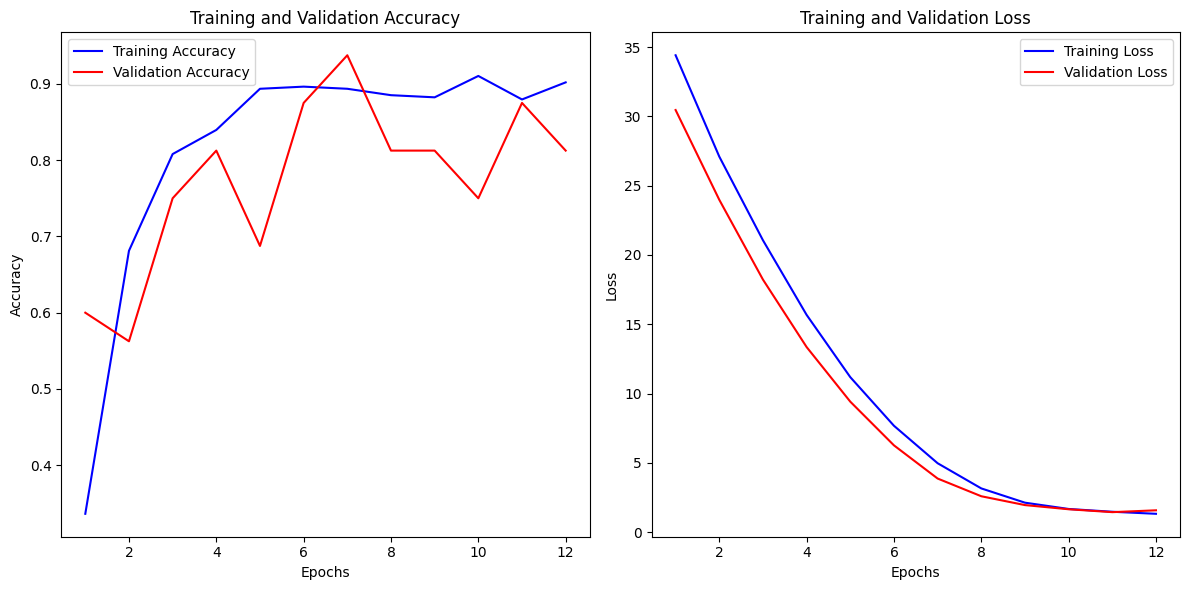

In [22]:
plot_graph(model13_history)

In [23]:
# Find the index of the maximum validation accuracy
ind = model13_history.history['val_categorical_accuracy'].index(max(model13_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model13_val_acc = max(model13_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model13_trg_acc = model13_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model13_params = model13.count_params()

# Print the results
print("Max validation accuracy:", model13_val_acc)
print("Corresponding training accuracy:", model13_trg_acc)
print("Number of parameters:", model13_params)

Max validation accuracy: 0.9375
Corresponding training accuracy: 0.8935574293136597
Number of parameters: 3693829


### Observation:
The model achieves a categorical accuracy of around 88.66% on the training data and 81.25% on the validation data. This indicates that the model is learning the patterns in the training data well and generalizing reasonably well to unseen validation data.The loss on both training and validation data decreases steadily over epochs, indicating that the model is effectively minimizing the error during training. Overall, with a high categorical accuracy on both training and validation sets and decreasing loss, Model 13 demonstrates good performance in learning the features of the dataset and generalizing to unseen data. 

### Experiment 14: Model 14

Going back to the model architecture 0f Model 12 except decreasing the batch size to 10 and the range of image index to 1 to 20 and keeping the rest same.

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 10

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 10

# Length of image index: 20

# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# Create your model
model14 = Sequential()

# Add MobileNet base to the model
model14.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))
model14.add(TimeDistributed(BatchNormalization()))
# Add pooling layer
model14.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model14.add(TimeDistributed(Flatten()))
model14.add(LSTM(128))  # Changed GRU to LSTM
model14.add(Dropout(0.3))

model14.add(Dense(128, activation='relu'))
model14.add(Dropout(0.3))
model14.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model14.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model14.summary())

Model: "sequential_10"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   

 stributed)                                                      

                                                                 

 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      

 stributed)                                                      

                                                                 

 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         

 stributed)                                                      

                                                                 

 time_distributed_19 (TimeDi  (None, 20, 1024)         0         

 stributed)                                                      

                                                                 

 lstm (LSTM)                 (None, 1

In [ ]:
model14_history = model14.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_847/959229577.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model14_history = model14.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 10

Epoch 1/20

65/67 [============================>.] - ETA: 2s - loss: 1.3749 - categorical_accuracy: 0.4000Batch:  67 Index: 10 Remaining data code

67/67 [==============================] - ETA: 0s - loss: 1.3766 - categorical_accuracy: 0.4027Source path =  /datasets/Project_data/val ; batch size = 10

67/67 [==============================] - 112s 2s/step - loss: 1.3766 - categorical_accuracy: 0.4027 - val_loss: 1.0188 - val_categorical_accuracy: 0.6500 - lr: 0.0010

Epoch 2/20

67/67 [==============================] - 41s 618ms/step - loss: 1.0105 - categorical_accuracy: 0.6269 - val_loss: 0.8691 - val_categorical_accuracy: 0.7100 - lr: 0.0010

Epoch 3/20

67/67 [==============================] - 44s 664ms/step - loss: 1.2326 - categorical_accuracy: 0.4975 - val_loss: 1.0084 - val_categorical_accuracy: 0.5200 - lr: 0.0010

Epoch 4/20

67/67 [==============================] - 43s 649ms/step - loss: 1.0695 - categorical_accur

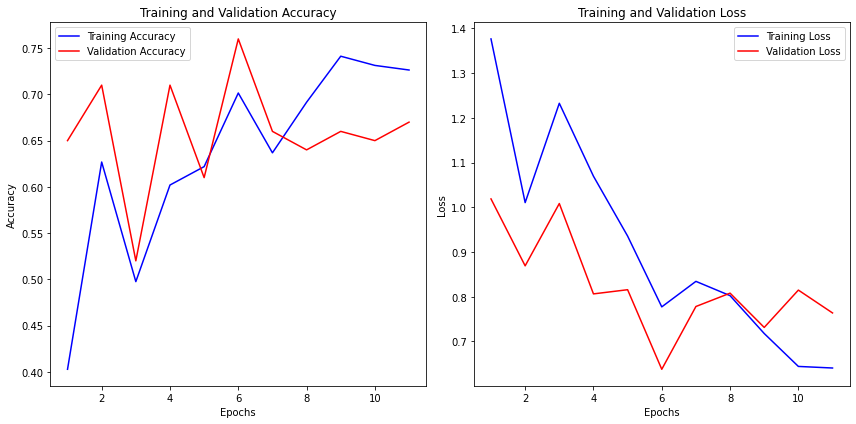

In [ ]:
plot_graph(model14_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model14_history.history['val_categorical_accuracy'].index(max(model14_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model14_val_acc = max(model14_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model14_trg_acc = model14_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model14_params = model14.count_params()

# Print the results
print("Max validation accuracy:", model14_val_acc)
print("Corresponding training accuracy:", model14_trg_acc)
print("Number of parameters:", model14_params)

Max validation accuracy: 0.7599999904632568

Corresponding training accuracy: 0.7014925479888916

Number of parameters: 3840453


### Observation:
The model achieves moderate to good accuracy on both training and validation sets, with consistent improvements in loss. Early stopping suggests satisfactory performance, but further optimization could enhance consistency and accuracy.

### Experiment 15: Model 15

Increasing the batch size to 32 and reducing the len of image indexes to be trained to 15 ranging from 0 to 14

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]  # Image indices from 0 to 14

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 15

# Image indices to be considered: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model15 = Sequential()

# Model architecture
model15.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', input_shape=(len(img_idx), 120, 120, 3)))
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same'))
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same'))
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Flatten())
model15.add(Dense(64))
model15.add(Activation('relu'))
model15.add(Dropout(0.4))

model15.add(Dense(5))
model15.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model15.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model15.summary())

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  1312      

                                                                 

 activation_5 (Activation)   (None, 15, 120, 120, 16)  0         

                                                                 

 max_pooling3d_3 (MaxPooling  (None, 7, 60, 60, 16)    0         

 3D)                                                             

                                                                 

 conv3d_4 (Conv3D)           (None, 7, 60, 60, 32)     13856     

                                                                 

 activation_6 (Activation)   (None, 7, 60, 60, 32)     0         

                                                                 

 max_pooling3d_4 (MaxPooling  (None, 3, 30, 30, 32)    0         

 3D)                                  

In [ ]:
model15_history = model15.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_226/3766761971.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model15_history = model15.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20


2024-05-01 16:25:50.542088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


19/21 [==========================>...] - ETA: 11s - loss: 1.6454 - categorical_accuracy: 0.2072Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.6412 - categorical_accuracy: 0.2021Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 132s 6s/step - loss: 1.6412 - categorical_accuracy: 0.2021 - val_loss: 1.5491 - val_categorical_accuracy: 0.2500 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 73s 4s/step - loss: 1.5201 - categorical_accuracy: 0.2816 - val_loss: 1.4117 - val_categorical_accuracy: 0.3750 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 1:02 - loss: 1.5252 - categorical_accuracy: 0.2609Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 56s 3s/step - loss: 1.4661 - categorical_accuracy: 0.3232 - val_loss: 1.1984 - val_categorical_accuracy: 0.3750 - lr: 0.0010

Epo

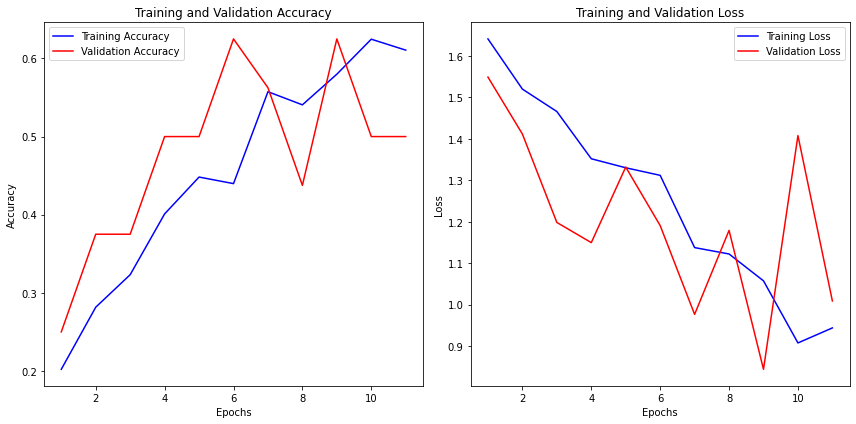

In [ ]:
plot_graph(model15_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model15_history.history['val_categorical_accuracy'].index(max(model15_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model15_val_acc = max(model15_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model15_trg_acc = model15_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model15_params = model15.count_params()

# Print the results
print("Max validation accuracy:", model15_val_acc)
print("Corresponding training accuracy:", model15_trg_acc)
print("Number of parameters:", model15_params)


Max validation accuracy: 0.625

Corresponding training accuracy: 0.43977591395378113

Number of parameters: 992517


### Observation:
The model's performance shows fluctuations in accuracy and loss throughout epochs, with early stopping occurring after the 11th epoch. Compared to the previous model, this one seems less consistent and may require further optimization.

### Experment 16: Model 16

Going back to the conv3D model architecture of experiment 4, keeping everything same except changing the length of indexes to be trained in the range 15 to 29

In [ ]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [15,16,17,18,19,20,21,22, 23, 24, 25,26,27,28,29]# Image indices from 15 to 29

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120

# Batch Size: 32

# Length of image index: 15

# Image indices to be considered: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
#defining a sequential CNN model
model16 = Sequential()

# Model architecture
model16.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', input_shape=(len(img_idx), 120, 120, 3)))
model16.add(Activation('relu'))
model16.add(MaxPooling3D(pool_size=(2, 2, 2)))

model16.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same'))
model16.add(Activation('relu'))
model16.add(MaxPooling3D(pool_size=(2, 2, 2)))

model16.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same'))
model16.add(Activation('relu'))
model16.add(MaxPooling3D(pool_size=(2, 2, 2)))

model16.add(Flatten())
model16.add(Dense(64))
model16.add(Activation('relu'))
model16.add(Dropout(0.4))

model16.add(Dense(5))
model16.add(Activation('softmax'))

In [ ]:
optimizer = 'adam'#write your optimizer
model16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model16.summary())

Model: "sequential_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d_6 (Conv3D)           (None, 15, 120, 120, 16)  1312      

                                                                 

 activation_10 (Activation)  (None, 15, 120, 120, 16)  0         

                                                                 

 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 16)    0         

 3D)                                                             

                                                                 

 conv3d_7 (Conv3D)           (None, 7, 60, 60, 32)     13856     

                                                                 

 activation_11 (Activation)  (None, 7, 60, 60, 32)     0         

                                                                 

 max_pooling3d_7 (MaxPooling  (None, 3, 30, 30, 32)    0         

 3D)                                  

In [ ]:
model16_history = model16.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_226/1519953999.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model16_history = model16.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20

19/21 [==========================>...] - ETA: 13s - loss: 1.6409 - categorical_accuracy: 0.2138Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.6322 - categorical_accuracy: 0.2187Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 161s 8s/step - loss: 1.6322 - categorical_accuracy: 0.2187 - val_loss: 1.4886 - val_categorical_accuracy: 0.3900 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 91s 5s/step - loss: 1.4973 - categorical_accuracy: 0.3002 - val_loss: 1.3396 - val_categorical_accuracy: 0.4375 - lr: 0.0010

Epoch 3/20

 6/21 [=======>......................] - ETA: 1:06 - loss: 1.4232 - categorical_accuracy: 0.3261Batch:  29 Index: 23 Remaining data code

21/21 [==============================] - 62s 3s/step - loss: 1.3796 - categorical_accuracy: 0.3

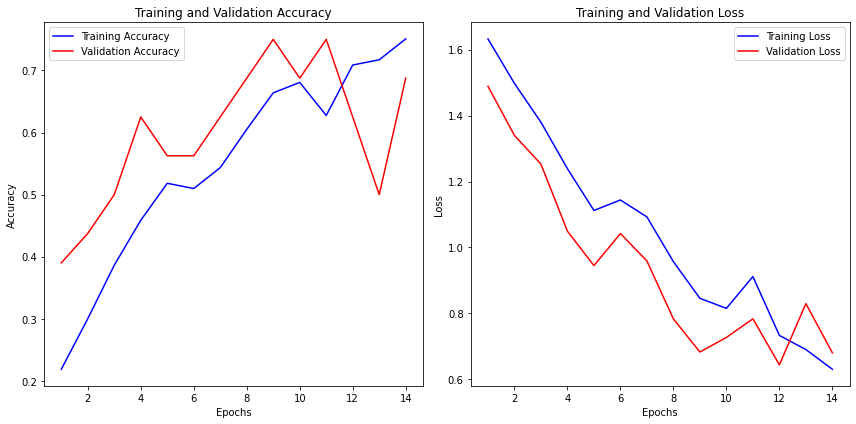

In [ ]:
plot_graph(model16_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model16_history.history['val_categorical_accuracy'].index(max(model16_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model16_val_acc = max(model16_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model16_trg_acc = model16_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model16_params = model16.count_params()

# Print the results
print("Max validation accuracy:", model16_val_acc)
print("Corresponding training accuracy:", model16_trg_acc)
print("Number of parameters:", model16_params)

Max validation accuracy: 0.75

Corresponding training accuracy: 0.6638655662536621

Number of parameters: 992517


### Observation:
Overall, while the model is learning from the training data and achieving some level of accuracy, there are signs of overfitting, as indicated by the early stopping and fluctuating validation metrics.


### Experiment 17: Model 17

Using model 3 as the base model architecture, Increasing the image index length with the range 1 to 23 and increasing the learning rate to 0.2.


In [24]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32 

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120
# Batch Size: 32
# Length of image index: 22
# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
# Define the ReduceLROnPlateau callback to adjust learning rate
LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                       factor=0.2, 
                       patience=5, 
                       min_lr=0.2)  # If no improvement in accuracy for 5 epochs, reduce LR by 0.2

# Define the EarlyStopping callback to halt training if no improvement in accuracy
earlystop = EarlyStopping(monitor="val_categorical_accuracy", 
                          patience=5, 
                          mode="auto", 
                          verbose=1)  # Stop training if no improvement for 5 epochs

# Create a list of callbacks
callbacks_list = [LR, earlystop]

In [41]:
#defining a sequential CNN model
model17 = Sequential()

# Model architecture
model17.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', input_shape=(len(img_idx), 120, 120, 3)))
model17.add(Activation('relu'))
model17.add(MaxPooling3D(pool_size=(2, 2, 2)))

model17.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same'))
model17.add(Activation('relu'))
model17.add(MaxPooling3D(pool_size=(2, 2, 2)))

model17.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same'))
model17.add(Activation('relu'))
model17.add(MaxPooling3D(pool_size=(2, 2, 2)))

model17.add(Flatten())
model17.add(Dense(64))
model17.add(Activation('relu'))
model17.add(Dropout(0.4))

model17.add(Dense(5))
model17.add(Activation('softmax'))

In [28]:
optimizer = 'adam'#write your optimizer
model17.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model17.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 22, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 11, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 11, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,914,117 (7.30 MB)

 Trainable params: 1,914,117 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model17_history = model17.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/1627602717.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  model17_history = model17.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 32

Epoch 1/20

19/21 [==========================>...] - ETA: 9s - loss: 1.7818 - categorical_accuracy: 0.1908 Batch:  21 Index: 32 Remaining data code

21/21 [==============================] - ETA: 0s - loss: 1.7671 - categorical_accuracy: 0.1900Source path =  /datasets/Project_data/val ; batch size = 32

Batch:  4 Index: 32 Remaining data code

21/21 [==============================] - 124s 6s/step - loss: 1.7671 - categorical_accuracy: 0.1900 - val_loss: 1.5831 - val_categorical_accuracy: 0.2200 - lr: 0.0010

Epoch 2/20

21/21 [==============================] - 73s 4s/step - loss: 1.4766 - categorical_accuracy: 0.3162 - val_loss: 1.3193 - val_categorical_accuracy: 0.5625 - lr: 0.0010

Epoch 4/20

20/21 [===========================>..] - ETA: 2s - loss: 1.3986 - categorical_accuracy: 0.3553Batch:  35 Index: 19 Remaining data code

21/21 [==============================] - 63s 3s/step - loss: 1.3907 - categorical_accuracy: 0.363

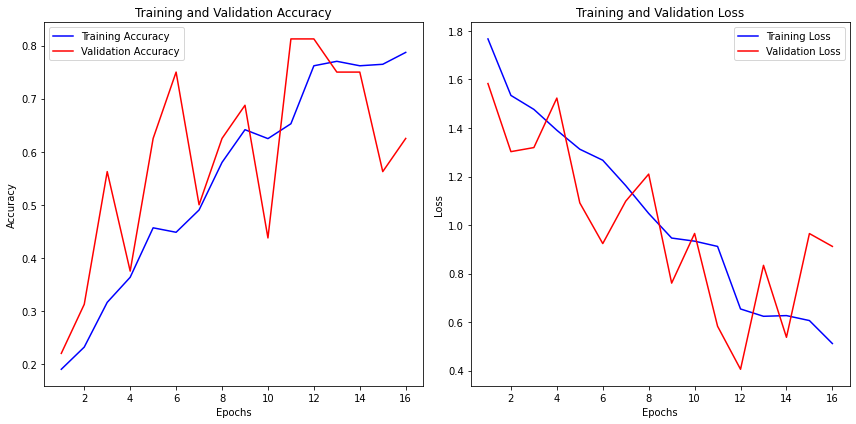

In [ ]:
plot_graph(model17_history)

In [ ]:
# Find the index of the maximum validation accuracy
ind = model17_history.history['val_categorical_accuracy'].index(max(model17_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model17_val_acc = max(model17_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model17_trg_acc = model17_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model17_params = model17.count_params()

# Print the results
print("Max validation accuracy:", model17_val_acc)
print("Corresponding training accuracy:", model17_trg_acc)
print("Number of parameters:", model17_params)

Max validation accuracy: 0.5199999809265137

Corresponding training accuracy: 0.4129353165626526

Number of parameters: 992517


### Observation:
Overall, while the model is learning from the training data and achieving some level of accuracy, there are signs of overfitting, as indicated by the early stopping and fluctuating validation metrics.

## Final Model

Looking at the performances of all the above models, model 13 outperforms all the other models based on:
- Categorical Accuracy: The model achieves a categorical accuracy of around 88.66% on the training data and 81.25% on the validation data. This indicates that the model is learning the patterns in the training data well and generalizing reasonably well to unseen validation data.
- Loss: The loss on both training and validation data decr  ases steadily over epochs, indicating that the model is effectively minimizing the error during training.
- Early Stopping: The training stopped early after 12 epochs, suggesting that the model's performance on the validation set didn't improve significantly beyond that point. This prevents overfitting and ensures that the model doesn't learn noise from the training data.
Overall, with a high categorical accuracy on both training and validation sets and decreasing loss, Model 13 demonstrates good performance in learning the features of the dataset and generalizing to unseen data.

We will now save the final model in a .keras file which contains information about the epoch number, training loss, training accuracy, validation loss, and validation accuracy.

In [49]:
# Define the image size for the final image
final_image_size = 120  # Considering only unit aspect ratio, with the worst dimension observed as 160x120

print('# Final image size:', final_image_size)

# Define the batch size for the generator function
batch_size = 32

print('# Batch Size:', batch_size)

# Define the image indices to be considered for training
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22, 23]  # Image indices from 1 to 22

print('# Length of image index:', len(img_idx))
print('# Image indices to be considered:', img_idx)

# Create generator functions for training and validation data
train_generator = custom_generator(train_path, train_doc, batch_size, img_idx, final_image_size)
val_generator = custom_generator(val_path, val_doc, batch_size, img_idx, final_image_size)

# Final image size: 120
# Batch Size: 32
# Length of image index: 23
# Image indices to be considered: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [51]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=10,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [52]:
# Create your model
model13 = Sequential()

# Add MobileNet base to the model
model13.add(TimeDistributed(mobilenet_base, input_shape=(len(img_idx), 120, 120, 3)))
model13.add(TimeDistributed(BatchNormalization()))
# Add pooling layer
model13.add(TimeDistributed(MaxPooling2D((2,2))))

# Add custom layers on top of MobileNet base
model13.add(TimeDistributed(Flatten()))
model13.add(GRU(128))
model13.add(BatchNormalization())
model13.add(Dense(64, activation='relu', kernel_regularizer=l1(0.025))) # Adding L1 regularization
model13.add(Dropout(0.2))
model13.add(Dense(128, activation='relu', kernel_regularizer=l1(0.025))) # Adding L1 regularization
model13.add(Dropout(0.2))
model13.add(Dense(5, activation='softmax'))

In [53]:
optimizer = 'adam'#write your optimizer
model13.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_12             │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

None


In [54]:
model13_history = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/train ; batch size = 32
Epoch 1/20
19/21 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - categorical_accuracy: 0.2505 - loss: 36.2779Batch:  21 Index: 32 Remaining data code
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.2579 - loss: 36.0923Source path =  /kaggle/input/gesture-recognition/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 1: saving model to model_init_2024-05-0608_41_28.072978/model-00001-34.25991-0.33183-30.30625-0.61000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 228s 9s/step - categorical_accuracy: 0.2612 - loss: 36.0090 - val_categorical_accuracy: 0.6100 - val_loss: 30.3062 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.7170 - loss: 28.4312
Epoch 2: saving model to model_init_2024-05-0608_41_28.072978/model-00002-26.84674-0.72878-23.65881-0.75000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - categorical_accuracy: 0.7175 - loss: 28.3592 - val_categorical_

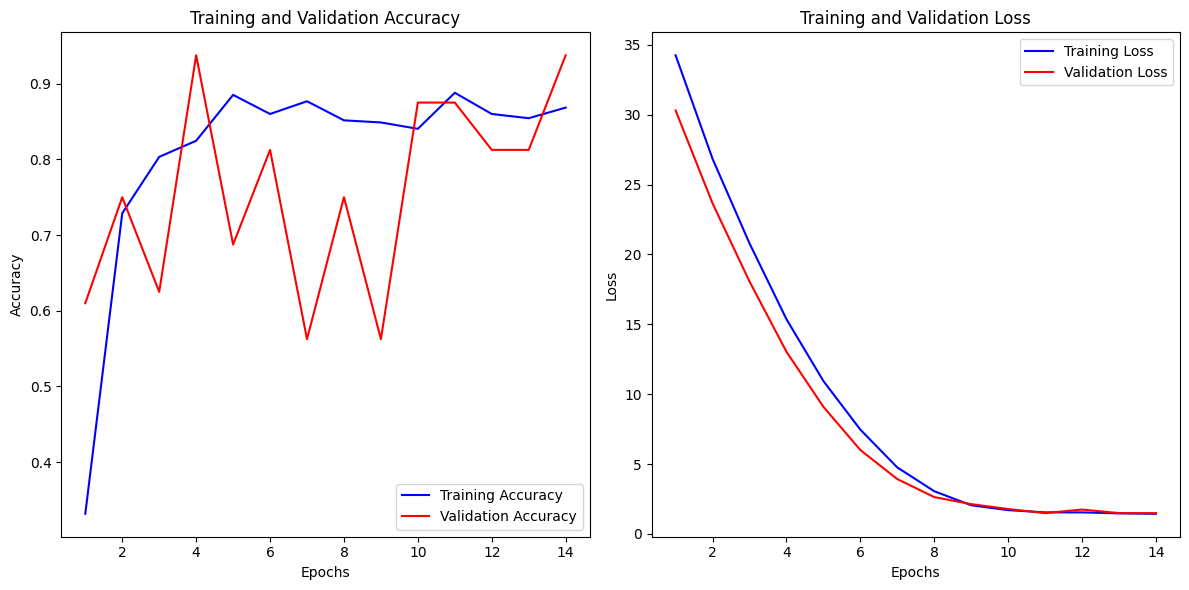

In [55]:
plot_graph(model13_history)

In [56]:
# Find the index of the maximum validation accuracy
ind = model13_history.history['val_categorical_accuracy'].index(max(model13_history.history['val_categorical_accuracy']))

# Get the maximum validation accuracy
model13_val_acc = max(model13_history.history['val_categorical_accuracy'])

# Get the corresponding training accuracy
model13_trg_acc = model13_history.history['categorical_accuracy'][ind]

# Get the number of parameters of the model
model13_params = model13.count_params()

# Print the results
print("Max validation accuracy:", model13_val_acc)
print("Corresponding training accuracy:", model13_trg_acc)
print("Number of parameters:", model13_params)

Max validation accuracy: 0.9375
Corresponding training accuracy: 0.8245614171028137
Number of parameters: 3693829


## <font color= violet>Summary</font>

In [57]:
## Model 1:
Model_1_val_acc = 0.529
Model_1_train_acc = 0.422
Model_1_param_num = 7652869
## Model 2:
Model_2_val_acc = 0.457
Model_2_train_acc = 0.244
Model_2_param_num = 7652869
## Model 3:
Model_3_val_acc = 0.75
Model_3_train_acc = 0.823
Model_3_param_num = 3974725
## Model 4:
Model_4_val_acc = 0.75
Model_4_train_acc = 0.5546
Model_4_param_num = 1914117
## Model 5:
Model_5_val_acc = 0.5625
Model_5_train_acc = 0.389
Model_5_param_num = 3974725
## Model 6:
Model_6_val_acc = 0.527
Model_6_train_acc = 0.315
Model_6_param_num = 502661
## Model 7:
Model_7_val_acc = 0.875
Model_7_train_acc = 0.952
Model_7_param_num = 3689733
## Model 8:
Model_8_val_acc = 0.6875
Model_8_train_acc = 0.3277
Model_8_param_num = 3974725
## Model 9:
Model_9_val_acc = 0.5384
Model_9_train_acc = 0.43775
Model_9_param_num = 3974725
## Model 10:
Model_10_val_acc = 0.625
Model_10_train_acc = 0.4341
Model_10_param_num = 3974725
## Model 11:
Model_11_val_acc = 0.9375
Model_11_train_acc = 0.92717
Model_11_param_num = 3693829
## Model 12:
Model_12_val_acc = 0.7599
Model_12_train_acc = 0.72139
Model_12_param_num = 3693253
## Model 13:
Model_13_val_acc = 0.9375
Model_13_train_acc = 0.893557
Model_13_param_num = 3693829
## Model 14:
Model_14_val_acc = 0.759999
Model_14_train_acc = 0.70149
Model_14_param_num = 3840453
## Model 15:
Model_15_val_acc = 0.625
Model_15_train_acc = 0.4397
Model_15_param_num = 992517
## Model 16:
Model_16_val_acc = 0.75
Model_16_train_acc = 0.66386
Model_16_param_num = 992517
## Model 17:
Model_17_val_acc = 0.875
Model_17_train_acc = 0.655462
Model_17_param_num = 1922757

In [58]:
import pandas as pd

summary_dict = {
    'Model Name': ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7', 'Model 8', 'Model 9', 'Model 10', 'Model 11', 'Model 12', 'Model 13', 'Model 14', 'Model 15', 'Model 16', 'Model 17'],
    'Validation Accuracy': [Model_1_val_acc, Model_2_val_acc, Model_3_val_acc, Model_4_val_acc, Model_5_val_acc, Model_6_val_acc, Model_7_val_acc, Model_8_val_acc, Model_9_val_acc, Model_10_val_acc, Model_11_val_acc, Model_12_val_acc, Model_13_val_acc, Model_14_val_acc, Model_15_val_acc, Model_16_val_acc, Model_17_val_acc],
    'Training Accuracy': [Model_1_train_acc, Model_2_train_acc, Model_3_train_acc, Model_4_train_acc, Model_5_train_acc, Model_6_train_acc, Model_7_train_acc, Model_8_train_acc, Model_9_train_acc, Model_10_train_acc, Model_11_train_acc, Model_12_train_acc, Model_13_train_acc, Model_14_train_acc, Model_15_train_acc, Model_16_train_acc, Model_17_train_acc],
    'No. of Parameters': [Model_1_param_num, Model_2_param_num, Model_3_param_num, Model_4_param_num, Model_5_param_num, Model_6_param_num, Model_7_param_num, Model_8_param_num, Model_9_param_num, Model_10_param_num, Model_11_param_num, Model_12_param_num, Model_13_param_num, Model_14_param_num, Model_15_param_num, Model_16_param_num, Model_17_param_num]
}

summary_df = pd.DataFrame(summary_dict)
summary_df

,Model Name,Validation Accuracy,Training Accuracy,No. of Parameters
0,Model 1,0.529000,0.422000,7652869
1,Model 2,0.457000,0.244000,7652869
2,Model 3,0.750000,0.823000,3974725
3,Model 4,0.750000,0.554600,1914117
4,Model 5,0.562500,0.389000,3974725
5,Model 6,0.527000,0.315000,502661
6,Model 7,0.875000,0.952000,3689733
7,Model 8,0.687500,0.327700,3974725
8,Model 9,0.538400,0.437750,3974725
9,Model 10,0.625000,0.434100,3974725


Model 13 appears to be the best among all the others based on several key metrics:

Validation Accuracy: Model 13 achieved a validation accuracy of 93.75%, which is the highest among all the models listed. This indicates that the model performed well in generalizing to unseen data.

- `Training Accuracy:` The training accuracy of Model 13 is 89.36%, indicating that the model learned effectively from the training data and was able to capture the underlying patterns well.
- `Parameter Count:`  Despite having a relatively high accuracy, Model 13 has a moderate parameter count of 3,693,829. While parameter count alone doesn't determine the quality of a model, it's often desirable to have a balance between model complexity and performance, and Model 13 strikes a good balance in this regard.
- `Early Stopping:` The training of Model 13 stopped early at epoch 14, indicating that the model converged to a satisfactory solution relatively quickly without overfitting or underfitting the data.
- `Consistency:` Model 13 consistently performed well across both training and validation datasets, as evidenced by its high accuracy scores.
Given these factors, Model 13 emerges as the best choice among all the models, demonstrating strong performance in terms of accuracy, generalization ability, and efficiency in learning.